# Исследование модели нейронной сети
В этой части лабораторных заданий  мы разработаем полносвязанную нейронную сеть для классификации изображений из базы данных CIFAR-10 и выполним проверку нейросети на тестовом множестве 

In [1]:
#Установки
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


# Для перезагрузки внешних модулей python;
# см. http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

Мы будем использовать класс `TwoLayerNet` из файла` cs231n / классификаторы / neural_net.py` для представления экземпляров сети. Параметры сети хранятся в переменной класса `self.params`, где ключи являются строковыми именами параметров, а значения - массивами numpy. Ниже мы создадим отладочный набор данных и одладочную модель, которые будем использовать в ходе разработки.


In [2]:
# Создание  небольшой сети и набора отладочных данных для проверки реализаций.
# Обратите внимание, что мы задаём seed  для повторяемости экспериментов.


input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

## Прямой путь: вычисление scores (рейтингов)

Откройте файл `cs231n/classifiers/neural_net.py` и просмотрите метод` TwoLayerNet.loss`. Эта функция очень похожа на функции, которые вы писали при реализации  SVM и Softmax классификаторов: она получает на вход  данные и веса и вычисляет рейтинги классов, потери и градиенты функции потерь.

Выполните первую часть прямого прохода по сети, которая использует веса и смещения, чтобы вычисленить рейтинги классов.


In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# Разность должна быть < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.680272093239262e-08


# Прямой путь: вычисление потерь

В той же функции реализуйте вторую часть, которая вычисляет потери на данных и потери регуляризации

In [4]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# разность должна быть < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


# Обратное распространение
Реализуйте оставшуюся часть функции. Она должна вычислять градиент функции потерь по переменным `W1`, `b1`, `W2`, и `b2`. Теперь, когда у Вас есть корректно реализванное прямое распространение, Вы можете отладить обратное распространение, используя проверку численного градиента. 

In [5]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.
# Используйте численную проверку градиента, чтобы проверить вашу реализацию обратного пути.
# Если ваша реализация верна, разница между численным и
# аналитическим градиентом должны быть меньше 1е-8 для каждого из параметров: W1, W2, b1 и b2.

loss, grads = net.loss(X, y, reg=0.05)

# относительная ошибка должна быть меньше или примерно 1e-8
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447646e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09


# Обучение сети

Для обучения сети будем использовать стохастический градиентный спуск (SGD), аналогичный классификаторам SVM и Softmax. Просмотрите на функцию `TwoLayerNet.train` и заполните отсутствующие части, реализующие процедуры обучения. Это должно очень похоже на процедуру обучения, которую Вы использовали для классификаторов SVM и Softmax. Вам также придется реализовать «TwoLayerNet.predict», поскольку процесс обучения периодически выполняет предсказание, чтобы отслеживать точность в ходе итераций.

После того, как Вы реализуете этот метод, запустите приведенный ниже код для обучения двухслойной сети на отладочных данных. Вы должны достичь значения потерь обучения менее 0,2.



Final training loss:  0.01869549348861238


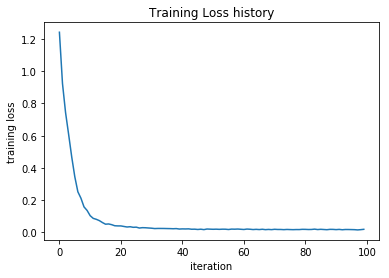

In [6]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# отображение функции потерь
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Загрузка данных
Теперь, когда Вы реализовали двухслойную сеть, которая проходит проверку градиента и работает с отладочными данными, пришло время загрузить базу CIFAR-10, чтобы мы могли использовать ее для обучения классификатора на реальном наборе данных.


In [7]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Загружает набор данных CIFAR-10 с диска и выполняет их предварительную 
    обработку для подачи на вход двухслойного нейронного классификатора. 
    
    """
    # Загрузка базы CIFAR-10 
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Выборка данных
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Нормализация данных: вычитание среднего изображения
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Вытягивание матриц в векторы
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test



# Очистка переменных для предотвращения повторной загрузки данных (что может вызвать проблемы с памятью)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Вызов функции, определенной выше, для получения данных.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Обучение сети
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.
Для обучения нашей сети будем использовать алгоритм SGD. Кроме того, будем управлять скоростью обучения с ппутём её экспоненциального затухания в процессе оптимизации; после каждой эпохи будем уменьшать скорость обучения, умножая ее на коэффициент затухания (decay rate).

In [8]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Обучение сети
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Предсказание на валидационном множестве
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)



iteration 0 / 1000: loss 2.302954
iteration 100 / 1000: loss 2.302595
iteration 200 / 1000: loss 2.298817
iteration 300 / 1000: loss 2.270446
iteration 400 / 1000: loss 2.219296
iteration 500 / 1000: loss 2.136532
iteration 600 / 1000: loss 2.061646
iteration 700 / 1000: loss 2.004998
iteration 800 / 1000: loss 2.019296
iteration 900 / 1000: loss 1.964284
Validation accuracy:  0.281


# Отладка процесса обучения

Используя приведенные выше параметры по умолчанию, вы должны получить на валидационном множестве точность, равную примерно 0.29. Это не очень хорошо.

Одна из стратегий получения информации о том, что не так, заключается в построении функции потерь и точности на обучающем и валидационном множествах в ходе оптимизации.

Другая стратегия - визуализировать обученные веса первого слоя сети. В большинстве нейронных сетей, обучающихся по изображениям, веса первого слоя обычно демонстрирует некоторую визуализируемую структуру.

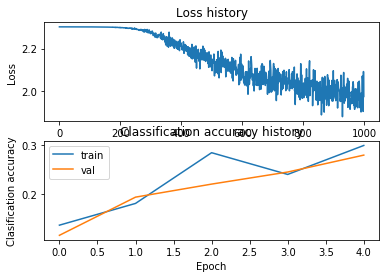

In [9]:
# Отображение функции потерь и точности обучения/валидации
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

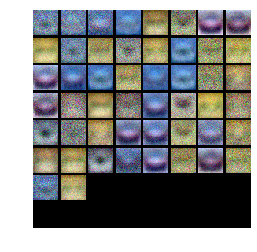

In [10]:
from cs231n.vis_utils import visualize_grid

# Визуализация весов нейронной сети

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Выбор гиперпараметров


**В чем проблема?**. Рассматривая визуализацию выше, мы видим, что потери уменьшаются более или менее линейно, что, по-видимому, указывает на то, что возможно скорость обучения слишком низкая. Более того, нет разрыва между точностью обучения и валидационной точностью, т.е. используемая нами модель имеет малую емкость и  мы должны увеличить число параметров модели. С другой стороны, при большом числе параметров возможно переобучение, которое проявляется в виде большого разрыва между точностью обучения и точностью валидации.

**Настройка**. Выбор гиперпараметров и развитие интуиции в отношении того, как они влияют на конечную эффективность, - это большая часть навыков применения нейросетей, поэтому мы хотим, чтобы Вы получили больше практики. Ниже Вы должны поэкспериментировать с различными значениями гиперпараметров, включая размер скрытого слоя, скорость обучения, количество эпох обучения и коэффициент регуляризации. Вы также можете рассмотреть возможность выбора коэффициента затухания скорости обучения, но Вы должны также получать хорошие результаты и при использовании значений по умолчанию.

**Примерные результаты**. Вы должны стремиться к достижению точности классификации, превышающей 48% валидационном множестве. Наша лучшая сеть имела точность более 52% в ходе валидации.

**Эксперимент**: Цель этого задания - получить как можно лучшие результаты на данных CIFAR-10 при использовании полносвязаной нейронной сети. Не стесняйтесь применять свои собственные методы (например, PCA, чтобы уменьшить размерность, или dropout или использовать признаки изображений т. д.).

In [11]:
best_net = None # здесь запоминаем наилучшую модель 

#################################################################################
# ЗАДАНИЕ: Выполните выбор гиперпараметров, используя множество валидации.      #
# Сохраните Вашу лучшую модель в  best_net.                                     #                                                           #
#                                                                               #
# Чтобы отладить вашу сеть, полезно использовать визуализацию, похожую на       #
# ту, которую мы использовали выше; эта визуализация будет иметь значительные   #
# качественные отличия от той,которую мы видели выше для плохо настроенной сети.#
#                                                                               #
# Настройка гиперпараметров вручную может быть интересной и может показаться    #
# Вам занимательной, но лучше написать код для перебора возможных комбинаций    #
# гиперпараметров, как мы делали это в предыдущих заданиях.                     #
#################################################################################
hidden_size = 75 

results = {}
best_val = -1
best_net = None

learning_rates = [2e-4,4e-4,6e-4,8e-4,1e-3]
regularization_strengths = [0.3,0.6,0.7,0.9]

for lr in learning_rates:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        stats = net.train(X_train, y_train, X_val, y_val,
        num_iters=150, batch_size=200,
        learning_rate=lr, learning_rate_decay=0.95,
        reg= reg, verbose=False)
        #if('val_acc_history' in stats):
        val_acc = stats['val_acc_history'][-1]
        #else:
         #   val_acc = (net.predict(X_val) == y_val).mean()
        if val_acc > best_val:
            best_val = val_acc
            best_net = net         
        results[(lr,reg)] = val_acc
        print ('lr %e reg %e val accuracy: %f' % (lr, reg,  val_acc))
        
# # Print out results.
# for lr, reg in sorted(results):
#     val_acc = results[(lr, reg)]
#     print ('lr %e reg %e val accuracy: %f' % (lr, reg,  val_acc))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)
#################################################################################
#                               КОНЕЦ ВАШЕГО КОДА                               #
#################################################################################

lr 2.000000e-04 reg 3.000000e-01 val accuracy: 0.402000
lr 2.000000e-04 reg 6.000000e-01 val accuracy: 0.400000
lr 2.000000e-04 reg 7.000000e-01 val accuracy: 0.390000
lr 2.000000e-04 reg 9.000000e-01 val accuracy: 0.401000
lr 4.000000e-04 reg 3.000000e-01 val accuracy: 0.450000
lr 4.000000e-04 reg 6.000000e-01 val accuracy: 0.459000
lr 4.000000e-04 reg 7.000000e-01 val accuracy: 0.458000
lr 4.000000e-04 reg 9.000000e-01 val accuracy: 0.459000
lr 6.000000e-04 reg 3.000000e-01 val accuracy: 0.457000
lr 6.000000e-04 reg 6.000000e-01 val accuracy: 0.460000
lr 6.000000e-04 reg 7.000000e-01 val accuracy: 0.455000
lr 6.000000e-04 reg 9.000000e-01 val accuracy: 0.463000
lr 8.000000e-04 reg 3.000000e-01 val accuracy: 0.478000
lr 8.000000e-04 reg 6.000000e-01 val accuracy: 0.480000
lr 8.000000e-04 reg 7.000000e-01 val accuracy: 0.482000
lr 8.000000e-04 reg 9.000000e-01 val accuracy: 0.465000
lr 1.000000e-03 reg 3.000000e-01 val accuracy: 0.497000
lr 1.000000e-03 reg 6.000000e-01 val accuracy: 0

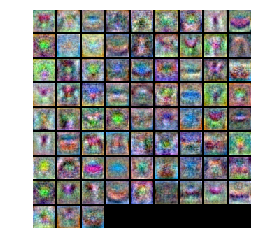

In [12]:
# визуализация весов лучшей сети
show_net_weights(best_net)

# Выполнение на тестовом множестве данных
Когда вы закончите экспериментирование, вы должны оценить окончательно обученную сеть на тестовом наборе; вы должны получить точность более 48%.


In [13]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.491


**Вопрос**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

Теперь, когда Вы обучили нейроклассификатор, вы можете обнаружить, что точность тестирования намного ниже, чем точность обучения. Каким образом мы можем уменьшить этот разрыв? Выбрать все ответы, которые подходят.
1. Обучать на большем наборе данных.
2. Добавить больше скрытых слоев.
3. Увеличить коэффициент регуляризации.
4. Ничего из перечисленного.

*Ваш ответ*: 1 и 2 

*Ваши объяснения:* 1 из-за того, что тестовые данные более разнопланые чем обучающие выборки, 2 из-за того что для распознаввания используются более сложные НС с большим количеством слоев(особенно сверточные)